In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


file_path = r"D:\Internship tasks\Axion_Ray_Take_Home_Assignment(for me)\Task_2\Data_Given\DA -Task 2.xlsx"

# Load the Excel file
df = pd.read_excel(file_path)

In [15]:
# Separate numeric and categorical/text columns. This helps organize the analysis.
def identify_column_types(df, id_cols=None):
    """
    Identify and categorize columns by their data types,
    reclassify identifier columns as categorical,
    and ignore false-positive potential datetime columns.
    """
    import pandas as pd
    
    # Default empty list for IDs
    id_cols = id_cols or []

    # Initial type identification
    # Treat identifier columns as categorical
    all_numeric      = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    datetime_cols    = df.select_dtypes(include=['datetime64']).columns.tolist()
    bool_cols        = df.select_dtypes(include=['bool']).columns.tolist()

    # Reclassify identifier/code columns as categorical
    for col in id_cols:
        if col in all_numeric:
            all_numeric.remove(col)
        if col in df.columns and col not in categorical_cols:
            categorical_cols.append(col)

    # Further categorize numeric columns into discrete vs continuous
    discrete_numeric   = []
    continuous_numeric = []
    for col in all_numeric:
        # Few unique values relative to dataset → discrete
        if df[col].nunique() < min(30, len(df) * 0.05):
            discrete_numeric.append(col)
        else:
            continuous_numeric.append(col)

    # Print summary
    print(f"Dataset Shape: {df.shape[0]} rows, {df.shape[1]} columns\n")
    print("Column Type Summary:")
    print(f"- Numeric Columns: {len(all_numeric)}")
    print(f"  • Continuous: {len(continuous_numeric)}")
    print(f"  • Discrete/Integer: {len(discrete_numeric)}")
    print(f"- Categorical/Text Columns: {len(categorical_cols)}")
    print(f"- Boolean Columns: {len(bool_cols)}")
    print(f"- Datetime Columns: {len(datetime_cols)}\n")

    # Print detailed lists
    print("Numeric Columns (Continuous):", continuous_numeric)
    print("\nNumeric Columns (Discrete/Integer):", discrete_numeric)
    print("\nCategorical/Text Columns:", categorical_cols)
    if bool_cols:
        print("\nBoolean Columns:", bool_cols)
    if datetime_cols:
        print("\nDatetime Columns:", datetime_cols)

    # Return dictionary of column types for further analysis
    return {
        'continuous_numeric': continuous_numeric,
        'discrete_numeric': discrete_numeric,
        'categorical': categorical_cols,
        'boolean': bool_cols,
        'datetime': datetime_cols
    }

# Usage example:
# Define columns that are identifiers or codes
id_columns = [
    'TRANSACTION_ID',
    'SRC_TXN_ID',
    'CAMPAIGN_NBR',
    'ORD_SELLING_SRC_CD',
    'TRANSACTION_CNTR',
    'GLOBAL_LABOR_CODE',
    'TRANSMISSION_SOURCE_PLANT',
    'PLANT',
    'ENGINE_SOURCE_PLANT',
    'SRC_VER_NBR',                 # added
    'LAST_KNOWN_DELVRY_TYPE_CD'    # added
]

# Call the function and store the result
column_types = identify_column_types(df, id_cols=id_columns)

# Print the returned dictionary to verify
print("\nReturned dictionary of column types:")
for key, value in column_types.items():
    print(f"{key}: {value}")

Dataset Shape: 100 rows, 52 columns

Column Type Summary:
- Numeric Columns: 9
  • Continuous: 5
  • Discrete/Integer: 4
- Categorical/Text Columns: 42
- Boolean Columns: 0
- Datetime Columns: 1

Numeric Columns (Continuous): ['REPAIR_AGE', 'KM', 'REPORTING_COST', 'TOTALCOST', 'LBRCOST']

Numeric Columns (Discrete/Integer): ['DEALER_REGION', 'COMPLAINT_CD_CSI', 'NON_CAUSAL_PART_QTY', 'SALES_REGION_CODE']

Categorical/Text Columns: ['VIN', 'CORRECTION_VERBATIM', 'CUSTOMER_VERBATIM', 'CAUSAL_PART_NM', 'GLOBAL_LABOR_CODE_DESCRIPTION', 'PLATFORM', 'BODY_STYLE', 'VPPC', 'PLANT', 'BUILD_COUNTRY', 'LAST_KNOWN_DLR_NAME', 'LAST_KNOWN_DLR_CITY', 'REPAIRING_DEALER_CODE', 'DEALER_NAME', 'REPAIR_DLR_CITY', 'STATE', 'REPAIR_DLR_POSTAL_CD', 'COMPLAINT_CD', 'VEH_TEST_GRP', 'COUNTRY_SALE_ISO', 'OPTN_FAMLY_CERTIFICATION', 'OPTF_FAMLY_EMISSIOF_SYSTEM', 'TRANSACTION_CATEGORY', 'ENGINE', 'ENGINE_DESC', 'TRANSMISSION', 'TRANSMISSION_DESC', 'ENGINE_SOURCE_PLANT', 'ENGINE_TRACE_NBR', 'TRANSMISSION_TRACE_NBR',

In [16]:
# Total missing per column
missing_counts = df.isnull().sum().sort_values(ascending=False)
# Percentage missing
missing_pct   = (missing_counts / len(df) * 100).round(2)
pd.concat([missing_counts, missing_pct], axis=1, keys=['MissingCount','MissingPct']).head(10)

,MissingCount,MissingPct
CAMPAIGN_NBR,100,100.0
ENGINE_TRACE_NBR,12,12.0
TRANSMISSION_TRACE_NBR,12,12.0
ENGINE_SOURCE_PLANT,12,12.0
TRANSMISSION_SOURCE_PLANT,12,12.0
OPTN_FAMLY_CERTIFICATION,10,10.0
TOTALCOST,6,6.0
OPTF_FAMLY_EMISSIOF_SYSTEM,5,5.0
CAUSAL_PART_NM,5,5.0
LAST_KNOWN_DELVRY_TYPE_CD,2,2.0


In [26]:
# First, make sure column_types dictionary exists and has the required keys
column_types = column_types if 'column_types' in locals() else {}

# 1. Unpack column lists from the returned dictionary with default empty lists if keys don't exist
continuous_numeric = column_types.get('continuous_numeric', [])
discrete_numeric = column_types.get('discrete_numeric', [])
categorical_cols = column_types.get('categorical', [])
datetime_cols = column_types.get('datetime', [])

# 2. Impute missing values in continuous numeric columns (median) if <5% missing
for col in continuous_numeric:
    if col in df.columns:  # Check if column exists in dataframe
        missing_pct = df[col].isnull().mean()
        if missing_pct < 0.05:
            df[col] = df[col].fillna(df[col].median())

# 3. Impute missing values in discrete numeric columns (mode) if <5% missing
for col in discrete_numeric:
    if col in df.columns:  # Check if column exists in dataframe
        missing_pct = df[col].isnull().mean()
        if missing_pct < 0.05:
            df[col] = df[col].fillna(df[col].mode()[0])

# 4. Impute missing values in categorical/text columns (placeholder) if <5% missing
for col in categorical_cols:
    if col in df.columns:  # Check if column exists in dataframe
        missing_pct = df[col].isnull().mean()
        if missing_pct < 0.05:
            df[col] = df[col].fillna("Unknown")

# 5. (Optional) Drop or flag columns with high missingness (>30%)
high_missing = [col for col in df.columns if df[col].isnull().mean() > 0.30]
print("Columns with >30% missing:", high_missing)

# 6. Verify that missing values have been handled
missing_summary = pd.concat([
    df.isnull().sum(),
    (df.isnull().mean() * 100).round(2)
], axis=1, keys=['MissingCount','MissingPct']).sort_values('MissingPct', ascending=False)

missing_summary.head(10)

Columns with >30% missing: []


,MissingCount,MissingPct
ENGINE_TRACE_NBR,12,12.0
TRANSMISSION_TRACE_NBR,12,12.0
ENGINE_SOURCE_PLANT,12,12.0
TRANSMISSION_SOURCE_PLANT,12,12.0
OPTN_FAMLY_CERTIFICATION,10,10.0
TOTALCOST,6,6.0
CAUSAL_PART_NM,5,5.0
OPTF_FAMLY_EMISSIOF_SYSTEM,5,5.0
TRANSMISSION,0,0.0
GLOBAL_LABOR_CODE,0,0.0


In [30]:
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.title()

In [32]:
for col in ['STATE', 'BODY_STYLE', 'TRANSACTION_CATEGORY']:
    print(f"\n– {col} –")
    print(df[col].value_counts(dropna=False).head(10))


– STATE –
STATE
Fl    9
Ca    9
Tx    8
Oh    6
Mi    5
On    5
Pa    5
Il    4
Mn    4
Bc    3
Name: count, dtype: int64

– BODY_STYLE –
BODY_STYLE
Crew Cab          50
4 Door Utility    37
4 Door Sedan      10
Single Cab         1
Extended Cab       1
2 Door Coupe       1
Name: count, dtype: int64

– TRANSACTION_CATEGORY –
TRANSACTION_CATEGORY
Freg        89
Freg_Pol    11
Name: count, dtype: int64


In [33]:
# Step 3.2 – Fixing Categorical Inconsistencies

# 1. Refresh categorical columns list to remove dropped columns (like CAMPAIGN_NBR)
categorical_cols = [col for col in categorical_cols if col in df.columns]

# 2. Strip whitespace and title-case all categorical values
for col in categorical_cols:
    df[col] = df[col].astype(str).str.strip().str.title()

# 3. Special handling for columns that use codes (like STATE) – convert to UPPERCASE
if 'STATE' in df.columns:
    df['STATE'] = df['STATE'].str.upper()

# 4. Preview cleaned values
for col in ['STATE', 'BODY_STYLE', 'TRANSACTION_CATEGORY']:
    if col in df.columns:
        print(f"\n– {col} –")
        print(df[col].value_counts(dropna=False).head(10))


– STATE –
STATE
FL    9
CA    9
TX    8
OH    6
MI    5
ON    5
PA    5
IL    4
MN    4
BC    3
Name: count, dtype: int64

– BODY_STYLE –
BODY_STYLE
Crew Cab          50
4 Door Utility    37
4 Door Sedan      10
Single Cab         1
Extended Cab       1
2 Door Coupe       1
Name: count, dtype: int64

– TRANSACTION_CATEGORY –
TRANSACTION_CATEGORY
Freg        89
Freg_Pol    11
Name: count, dtype: int64


In [34]:
# Step 3.2.1 – Fixing specific known categorical typos

# Replace likely misspellings in TRANSACTION_CATEGORY
df['TRANSACTION_CATEGORY'] = df['TRANSACTION_CATEGORY'].replace({
    'Freg': 'Freight',
    'Freg_Pol': 'Freight_Policy'
})

# Confirm the correction
print(df['TRANSACTION_CATEGORY'].value_counts())

TRANSACTION_CATEGORY
Freight           89
Freight_Policy    11
Name: count, dtype: int64


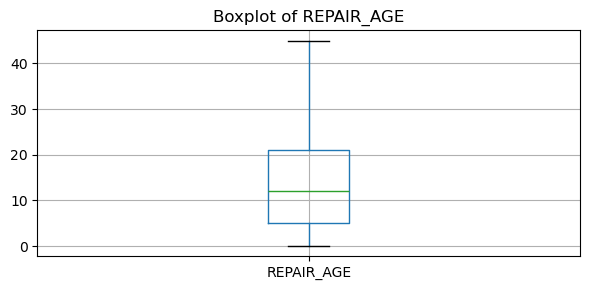

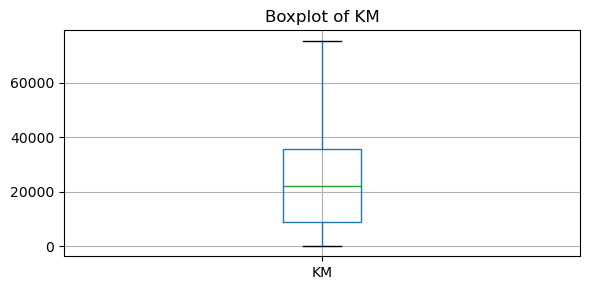

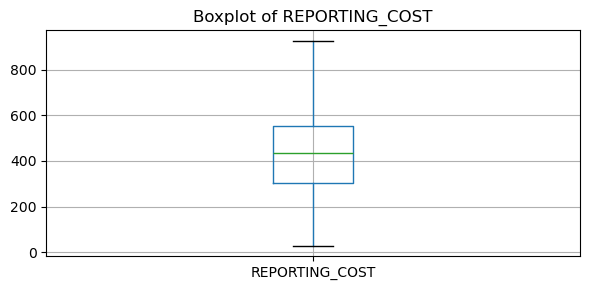

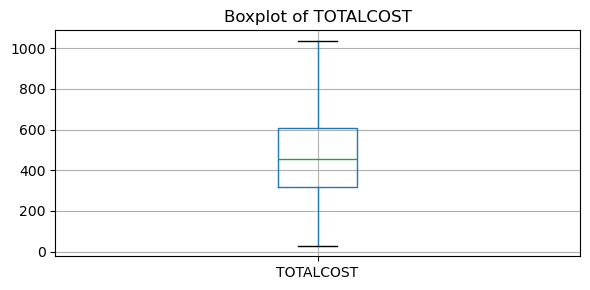

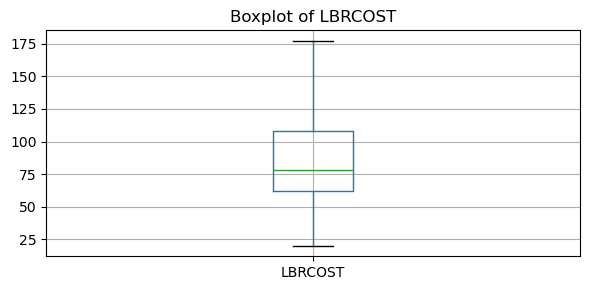


✅ Outlier treatment completed for continuous numeric columns.


In [36]:
# Step 3.3 – Outlier Detection and Treatment (IQR method)

# 1. Boxplots to visualize outliers
for col in continuous_numeric:
    plt.figure(figsize=(6, 3))
    df.boxplot(column=col)
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

# 2. Function to cap outliers using IQR
def cap_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return series.clip(lower, upper)

# 3. Apply outlier capping to continuous numeric columns
for col in continuous_numeric:
    df[col] = cap_outliers(df[col])

print("\n✅ Outlier treatment completed for continuous numeric columns.")

In [37]:
# Step 4.1 – Manually select 5 critical columns for business insight

# Based on domain relevance and variety, we choose:
critical_columns = [
    'REPAIR_AGE',                # Age of vehicle at repair – helps understand wear and tear
    'KM',                        # Usage – total kilometers run
    'TRANSACTION_CATEGORY',      # Type of transaction (Freight, Policy, etc.)
    'BODY_STYLE',                # Vehicle type – may influence cost/failure patterns
    'REPORTING_COST'             # Cost reported – directly impacts business
]

# Show basic stats for these
print("Critical Column Overview:\n")
for col in critical_columns:
    print(f"{col}:")
    print(df[col].describe(include='all'))
    print("-" * 50)

Critical Column Overview:

REPAIR_AGE:
count    100.000000
mean      14.820000
std       12.049879
min        0.000000
25%        5.000000
50%       12.000000
75%       21.000000
max       45.000000
Name: REPAIR_AGE, dtype: float64
--------------------------------------------------
KM:
count      100.000000
mean     24535.295000
std      19511.035731
min          3.000000
25%       8883.250000
50%      21962.000000
75%      35493.250000
max      75408.250000
Name: KM, dtype: float64
--------------------------------------------------
TRANSACTION_CATEGORY:
count         100
unique          2
top       Freight
freq           89
Name: TRANSACTION_CATEGORY, dtype: object
--------------------------------------------------
BODY_STYLE:
count          100
unique           6
top       Crew Cab
freq            50
Name: BODY_STYLE, dtype: object
--------------------------------------------------
REPORTING_COST:
count    100.000000
mean     463.194875
std      239.743675
min       27.690000
25%    

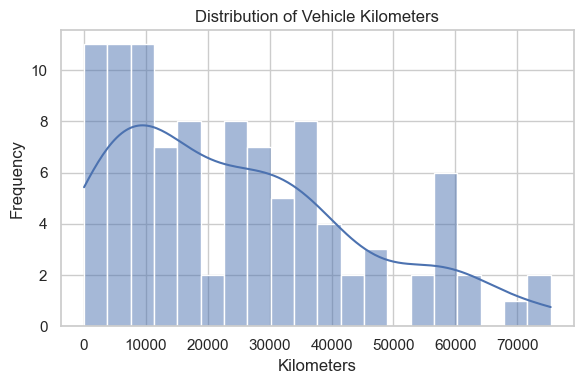

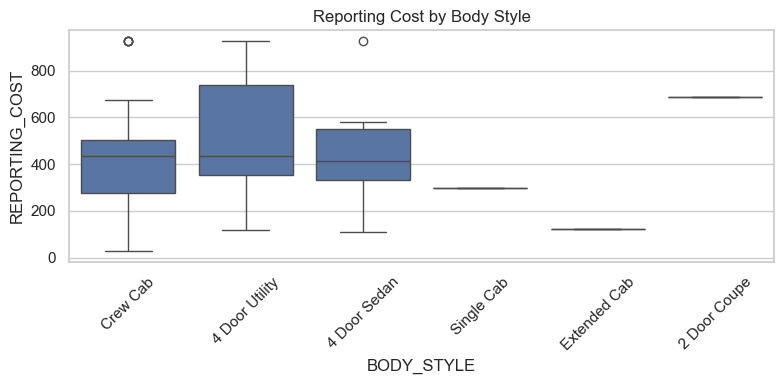

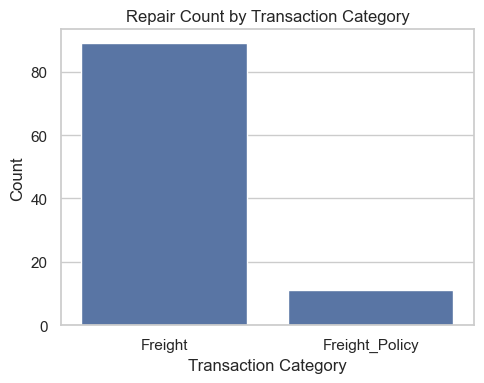

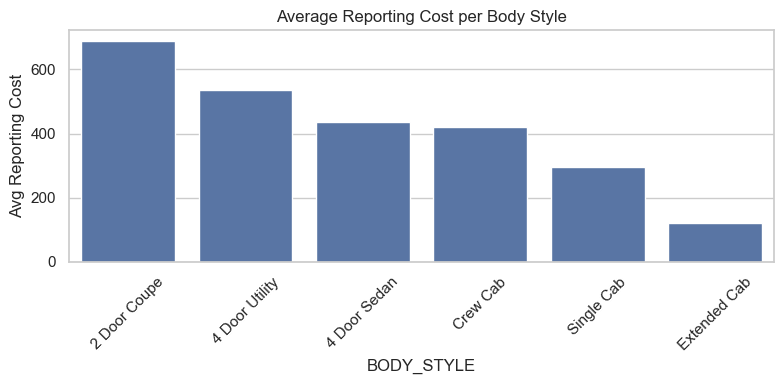

In [38]:

# Set plot style
sns.set(style="whitegrid")

# 1. Histogram – Distribution of vehicle KM
plt.figure(figsize=(6, 4))
sns.histplot(df['KM'], kde=True, bins=20)
plt.title("Distribution of Vehicle Kilometers")
plt.xlabel("Kilometers")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# 2. Boxplot – Reporting cost vs. body style
plt.figure(figsize=(8, 4))
sns.boxplot(x='BODY_STYLE', y='REPORTING_COST', data=df)
plt.title("Reporting Cost by Body Style")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 3. Countplot – Number of Repairs by Transaction Category
plt.figure(figsize=(5, 4))
sns.countplot(x='TRANSACTION_CATEGORY', data=df)
plt.title("Repair Count by Transaction Category")
plt.xlabel("Transaction Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ✅ Optional Bonus – Avg cost per body style (bar plot)
plt.figure(figsize=(8, 4))
avg_cost = df.groupby('BODY_STYLE')['REPORTING_COST'].mean().sort_values(ascending=False)
sns.barplot(x=avg_cost.index, y=avg_cost.values)
plt.title("Average Reporting Cost per Body Style")
plt.ylabel("Avg Reporting Cost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [42]:
import re
from sklearn.feature_extraction.text import CountVectorizer

# Step 5 – Generate tags from free-text

# 1. Define function to clean and extract keywords
def extract_tags(text_series, n_top=10):
    # Basic cleanup
    cleaned_text = text_series.dropna().str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))
    
    # Use CountVectorizer to find top keywords
    vectorizer = CountVectorizer(stop_words='english', max_features=100)
    X = vectorizer.fit_transform(cleaned_text)
    word_counts = X.toarray().sum(axis=0)
    
    vocab = vectorizer.get_feature_names_out()
    freq = dict(zip(vocab, word_counts))
    
    # Return top N sorted keywords
    return sorted(freq.items(), key=lambda x: x[1], reverse=True)[:n_top]

# 2. Extract top tags
customer_tags = extract_tags(df['CUSTOMER_VERBATIM'], n_top=10)
correction_tags = extract_tags(df['CORRECTION_VERBATIM'], n_top=10)

# 3. Print the generated tags
print("Top Tags – Customer Complaints:")
for tag, count in customer_tags:
    print(f"{tag}: {count}")

print("\nTop Tags – Corrections:")
for tag, count in correction_tags:
    print(f"{tag}: {count}")

Top Tags – Customer Complaints:
steering: 100
wheel: 100
states: 58
customer: 55
coming: 25
heated: 18
sop: 18
cs: 15
apart: 13
advise: 12

Top Tags – Corrections:
wheel: 125
steering: 123
replaced: 52
replace: 24
removed: 17
heated: 14
module: 14
pra: 12
verified: 12
new: 11
